# LSTM Model for LMP Prediction

### Step 0 - Import dependencies

Requirements for Windows: Keras 2.0.8 & Tensorflow 1.4.0

To learn more about sklearn.metrics visit: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

Keras Recurrent Layers documentation (look for LSTM):https://keras.io/layers/recurrent/ 

In [1]:
#Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score


Using TensorFlow backend.


### Step 1 - Data preprocesssing

In [2]:
#Upload CSV file

dataset = pd.read_csv('../BCA_MDA_ZONALPRICES.csv')

#Select zone to analyze

selected_zone = "ENSENADA"
working_df = dataset[dataset['ZONE'] == selected_zone]

index_training = working_df.query('DATE == "2019-01-01"').index.tolist()
index_training = min(index_training) -1

training_set = working_df.loc[:index_training, ['MDA LMP']].values

# Feature Scaling

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with a predefined number of timesteps and 1 output

timesteps= 60
stop_train= len(training_set)

X_train = []
y_train = []


for i in range(timesteps, stop_train):
    X_train.append(training_set_scaled[i-timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#Remember that the 3D tensor has the input shape (batch_size, timesteps, input_dim)


### Step 2 - Reprocessing Neural Network

In [3]:
# Initialising the RNN
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae'])

# Fitting the RNN to the Training set
History = model.fit(X_train, y_train, epochs = 19, batch_size = 32)

Epoch 1/19
25620/25620 [==============================] - 140s - loss: 0.0028 - mean_absolute_error: 0.0217   
Epoch 2/19
25620/25620 [==============================] - 136s - loss: 0.0017 - mean_absolute_error: 0.0162   
Epoch 3/19
25620/25620 [==============================] - 137s - loss: 0.0014 - mean_absolute_error: 0.0147   
Epoch 4/19
25620/25620 [==============================] - 138s - loss: 0.0012 - mean_absolute_error: 0.0134   
Epoch 5/19
25620/25620 [==============================] - 137s - loss: 0.0011 - mean_absolute_error: 0.0133   
Epoch 6/19
25620/25620 [==============================] - 139s - loss: 0.0011 - mean_absolute_error: 0.0127   
Epoch 7/19
25620/25620 [==============================] - 137s - loss: 0.0011 - mean_absolute_error: 0.0126   
Epoch 8/19
25620/25620 [==============================] - 137s - loss: 0.0011 - mean_absolute_error: 0.0125   
Epoch 9/19
25620/25620 [==============================] - 137s - loss: 0.0010 - mean_absolute_error: 0.0123   
E

### Step 3 - Making predictions

In [4]:
# Getting the test set (corresponding to 2019 prices)
index_set = index_training - timesteps
test_set = working_df.loc[index_set:, ['MDA LMP']].values

# Getting the predicted LMP price for 2019
inputs = test_set.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

stop_test= len(test_set)

for i in range(timesteps, stop_test):
    X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_LMP_price = model.predict(X_test)
predicted_LMP_price = sc.inverse_transform(predicted_LMP_price)

### Step 4 - Plot the results

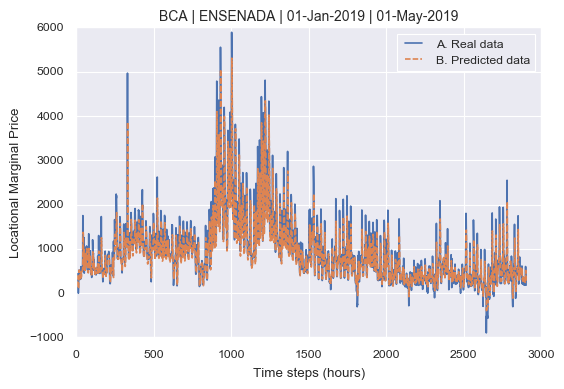

In [22]:
#Get real data for 2019
index_real = index_training 
real_LMP_price = working_df.loc[index_real:, ['MDA LMP']].values

#Make graph for the predicted and real LMPs using Seaborn feautures
seaborn_real = real_LMP_price.ravel()
seaborn_real = seaborn_real.tolist()

seaborn_predicted = predicted_LMP_price.ravel()
seaborn_predicted = seaborn_predicted.tolist()

seaborn_data = {'B. Predicted data': seaborn_predicted,'A. Real data': seaborn_real} 
seaborn_df = pd.DataFrame(seaborn_data) 

sns.set()
sns.set_context("paper")
ax= sns.lineplot(data=seaborn_df)
ax.tick_params(left=False, bottom=False, right=False, top=False)
ax.set(xlabel='Time steps (hours)', ylabel='Locational Marginal Price')
results_title = "BCA | " + selected_zone + " | 01-Jan-2019 | 01-May-2019"
ax.set_title(results_title).set_fontsize('10')

save_results = "LSTM_Figures/" + selected_zone + "_Forecast.png"
plt.savefig(save_results)

plt.show()


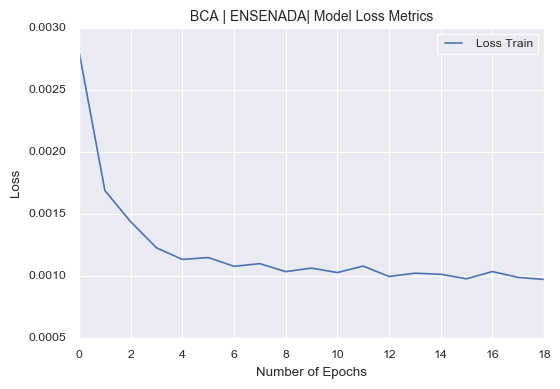

In [21]:
#Make graph for the model loss metrics
seaborn_loss = History.history['loss']

#seaborn_acc_test = History.history['val_acc']

seaborn_data = {'Loss Train': seaborn_loss} 
seaborn_df = pd.DataFrame(seaborn_data) 


sns.set_context("paper")
ax= sns.lineplot(data=seaborn_df)
ax.tick_params(left=False, bottom=False, right=False, top=False)
ax.set(xlabel='Number of Epochs', ylabel='Loss')
error_title = "BCA | " + selected_zone + "| Model Loss Metrics"
ax.set_title(error_title).set_fontsize('10')

save_loss = "LSTM_Figures/" + selected_zone + "_loss.png"
plt.savefig(save_loss)

plt.show()


### Step 5 - Compute regression metrics to asses the model accuracy

In [8]:
#Use the modules from sklearn.metrics

y_true = real_LMP_price
y_pred = predicted_LMP_price

evs = explained_variance_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mdae = median_absolute_error(y_true, y_pred)
r2s = r2_score(y_true, y_pred)


print("Explained variance score: " + str(evs))
print("")
print("Mean absolute error: " + str(mae))
print("")
print("Mean squared error: " + str(mse))
print("")
print("Median absolute error: " + str(mdae))
print("")
print("R2 score: " + str(r2s))


Explained variance score: 0.8610461217491248

Mean absolute error: 173.50619358684736

Mean squared error: 84042.0747828656

Median absolute error: 97.06270751953127

R2 score: 0.8527415855787492
